<a href="https://colab.research.google.com/github/KFurudate/Midoribon/blob/main/chap9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第9章 GLMのベイズモデル化と事後分布の推定


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.special import comb
from scipy import stats
%matplotlib inline

In [3]:
data_dir = "/content/drive/My Drive/Midoribon/input/"
data =  pd.read_csv(os.path.join(data_dir, 'chap9_data.csv'))

In [4]:
print(len(data))
data

20


,x,y
0,3.000000,5
1,3.210526,3
2,3.421053,6
3,3.631579,7
4,3.842105,7
5,4.052632,5
6,4.263158,9
7,4.473684,9
8,4.684211,7
9,4.894737,10


In [5]:
data.describe()

,x,y
count,20.00000,20.000000
mean,5.00000,7.300000
std,1.24549,2.408319
min,3.00000,3.000000
25%,4.00000,5.750000
50%,5.00000,7.000000
75%,6.00000,9.000000
max,7.00000,12.000000


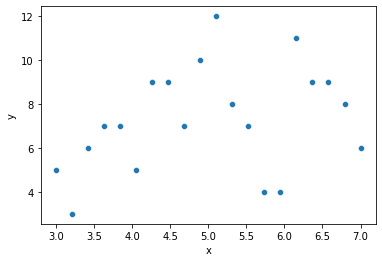

In [6]:
sns.scatterplot(x='x', y='y', data=data)
plt.show()

In [7]:
# 切片β1lと 傾きβ2の最尤推定値
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.glm('y ~ x', data=data, family=sm.families.Poisson())
result = model.fit()
result.summary2()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary2.Summary'>
"""
              Results: Generalized linear model
=============================================================
Model:              GLM              AIC:            94.0358 
Link Function:      log              BIC:            -39.7525
Dependent Variable: y                Log-Likelihood: -45.018 
Date:               2020-10-05 02:22 LL-Null:        -45.763 
No. Observations:   20               Deviance:       14.171  
Df Model:           1                Pearson chi2:   13.6    
Df Residuals:       18               Scale:          1.0000  
Method:             IRLS                                     
--------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|    [0.025  0.975]
--------------------------------------------------------------
Intercept    1.5661    0.3599  4.3508  0.0000   0.8606  2.2715
x            0.0833    0.0684  1.2187  0.2230  -0.0507  0.2174
=============================================================

"""

In [8]:
# Parameter(coefficent)
# intercept
β1 = 1.5661

# slope
β2 =	0.0833

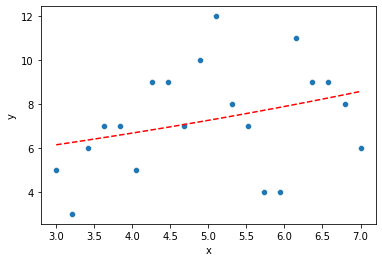

In [9]:
sns.scatterplot(x='x', y='y', data=data)

# ポアソン回帰モデルによる平均種子数λiの予測 
# λi = exp(β1+ β2xi)
x = np.linspace(3, 7)
y = np.exp(β1 + x*β2)
plt.plot(x, y, "r--")

plt.show()

### GLMのベイズモデル化

個体$i$の種子数$y_i$のばらつきを平均$\lambda_i$のポアソン分布$p(y_i|\lambda_i)$に従うとする。

平均を$
\lambda_i = \exp(\beta_1+\beta_2 x_i)
$と指定する。



モデルの尤度関数は、
$$
L(\beta_1,\beta_2)=\prod_i p(y_i|\lambda_i) = \prod_i p(y_i|\beta_1,\beta_2,x_i)
$$
となる。

ベイズモデルの事後分布は、(尤度)$\times$(事前分布)に比例するので、以下の関係が成り立つ。

$$
p(\beta_1,\beta_2|{\bf Y}) \propto p({\bf Y}|\beta_1,\beta_2) p(\beta_1) p(\beta_2)
$$


In [10]:
pip install pymc3==3.9.3

In [11]:
import pymc3

In [12]:
with pymc3.Model() as model:
    # 無情報事前分布をN(0, 100)の正規分布で設定
    beta1 = pymc3.Normal('beta1', mu=0, sd=100)
    beta2 = pymc3.Normal('beta2', mu=0, sd=100)
    
    # 線形予測子θをβ1+β2xで設定
    theta = beta1 + beta2*data['x'].values
    
    # ログリンク関数(log(μ)=θ⇔μ=exp(θ))を設定し、ポアソン分布で推定する
    y = pymc3.Poisson('y', mu=np.exp(theta), observed=data['y'].values)

Sequential sampling (2 chains in 1 job)
HamiltonianMC: [beta2, beta1]


Sampling 2 chains for 100 tune and 1_500 draw iterations (200 + 3_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.9156712318480589, but should be close to 0.65. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9539304299152647, but should be close to 0.65. Try to increase the number of tuning steps.
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta1,1.556,0.403,0.816,2.286,0.009,0.006,2009.0,2009.0,2195.0,202.0,1.01
beta2,0.084,0.076,-0.045,0.233,0.002,0.003,1877.0,255.0,1993.0,176.0,1.01


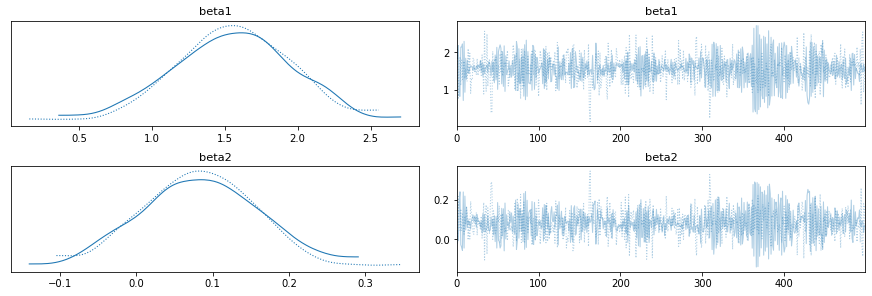

In [13]:
# ハミルトニアンモンテカルロ法
with model:
    step = pymc3.HamiltonianMC()
    trace = pymc3.sample(1500, step=step, tune=100, random_seed=42)[::3]
    
_ = pymc3.traceplot(trace)

pymc3.summary(trace)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]


Sampling 2 chains for 100 tune and 1_500 draw iterations (200 + 3_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta1,1.289,0.436,0.654,1.949,0.292,0.242,2.0,2.0,3.0,21.0,2.17
beta2,0.135,0.083,0.028,0.261,0.056,0.046,2.0,2.0,3.0,19.0,2.25


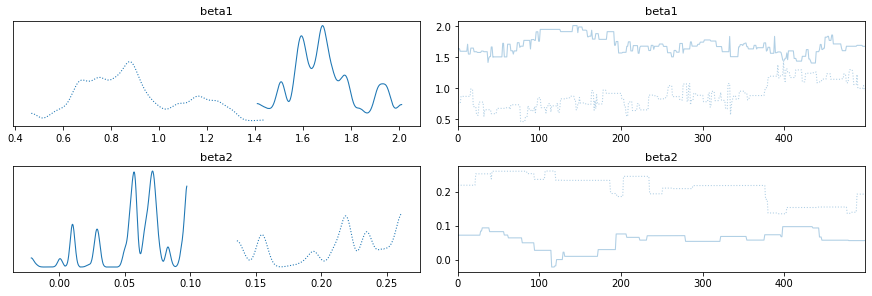

In [14]:
# メトロポリス法
with model:
    step = pymc3.Metropolis()
    trace = pymc3.sample(1500, step=step, tune=100, random_seed=42)[::3]
    
_ = pymc3.traceplot(trace)

pymc3.summary(trace)

Sequential sampling (2 chains in 1 job)
NUTS: [beta2, beta1]


Sampling 2 chains for 100 tune and 1_500 draw iterations (200 + 3_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.9361584172493919, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9421744822534625, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less acc

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta1,1.542,0.376,0.879,2.277,0.018,0.013,422.0,410.0,421.0,521.0,1.0
beta2,0.086,0.071,-0.054,0.206,0.004,0.002,411.0,411.0,409.0,541.0,1.0


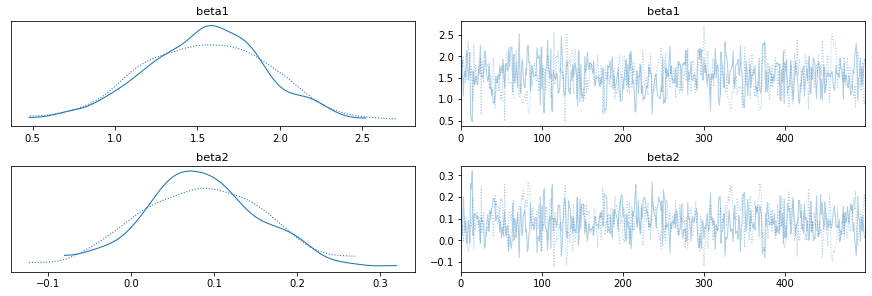

In [15]:
# NUTS(デフォルト)
with model:
    step = pymc3.NUTS()
    trace = pymc3.sample(1500, step=step, tune=100, random_seed=42)[::3]
    
_ = pymc3.traceplot(trace)

pymc3.summary(trace)

### MCMCサンプルから事後分布を推定

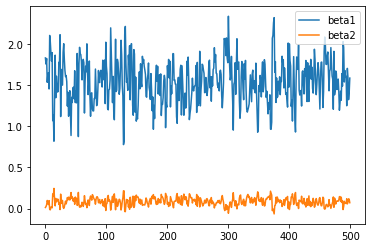

In [16]:
# 同時事後分布p(β1,β2|Y)のプロット
beta1_averages = np.zeros(len(trace), dtype=np.float64)
beta2_averages = np.zeros(len(trace), dtype=np.float64)

for i in trace.chains:
    beta1_averages += trace.get_values('beta1', chains=i) / trace.nchains
    beta2_averages += trace.get_values('beta2', chains=i) / trace.nchains

plt.plot(beta1_averages, label='beta1')
plt.plot(beta2_averages, label='beta2')
plt.legend()
plt.show()

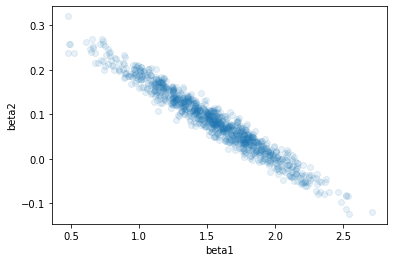

In [17]:
# 同時事後分布p(β1,β2|Y)を散布図でプロット
plt.scatter(trace.get_values('beta1'), trace.get_values('beta2'), alpha=0.1)
plt.xlabel('beta1')
plt.ylabel('beta2')
plt.show()

In [18]:
df_sample = pd.DataFrame()
df_sample["beta1"] = beta1_averages
df_sample["beta2"] = beta2_averages
df_sample

,beta1,beta2
0,1.828324,0.014176
1,1.753431,0.026220
2,1.821392,0.047438
3,1.532849,0.099399
4,1.629587,0.071902
...,...,...
495,1.701701,0.057449
496,1.592045,0.077109
497,1.322180,0.119912
498,1.404065,0.113873


In [19]:
pymc3.summary(trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta1,1.542,0.376,0.879,2.277,0.018,0.013,422.0,410.0,421.0,521.0,1.0
beta2,0.086,0.071,-0.054,0.206,0.004,0.002,411.0,411.0,409.0,541.0,1.0


In [20]:
#事後分布からの平均値
β1 = 1.542
β2 = 0.086

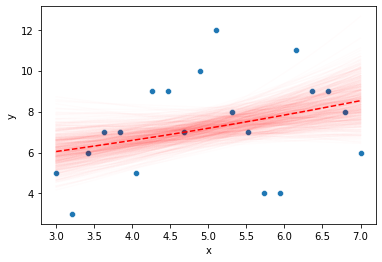

In [36]:
#事後分布から平均λの予測
xx = np.linspace(3,7,100)

for i in range(df_sample.shape[0]):
    beta1 = df_sample.beta1[i]
    beta2 = df_sample.beta2[i]

    yy = np.exp(beta1+beta2*(xx))
    plt.plot(xx, yy, color="R", alpha=0.01)

sns.scatterplot(x='x', y='y', data=data)

# ポアソン回帰モデルによる平均種子数λiの予測 
# λi = exp(β1+ β2xi)
x = np.linspace(3, 7)
y = np.exp(β1 + x*β2)
plt.plot(x, y, "r--")

plt.show()